In [47]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
import urllib        #for url stuff
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os                # for os commands
import nltk
from nltk.corpus import stopwords
import string
#import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

In [48]:
train_df = pd.read_csv('train.tsv', sep='\t')
train_df.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [49]:
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [50]:
train_df['temp']=train_df['category_name'].str.count('/')
train_df['temp'].value_counts()

2.0    1471819
4.0       3059
3.0       1330
Name: temp, dtype: int64

In [51]:
train_df[train_df['temp']>2].head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,temp
239,239,Zagg invisible shield for IPad air,1,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,10.0,1,Zag invisible shield for IPad air,4.0
742,742,iPad Pro Smart Cover,2,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,31.0,0,iPad Pro Smart Cover in Lilac Made for iPad Pr...,4.0
1700,1700,LIKE NEW KOBO eReader Tablet Only [rm]!!,1,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,31.0,0,Selling a tablet literally like new. No scratc...,4.0
2828,2828,Leotard,3,Sports & Outdoors/Exercise/Dance/Ballet,NaN,30.0,0,Competition Leo. only worn once for one comp. ...,3.0
2923,2923,Vuru tablet. 7 inch.,3,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,26.0,0,Vuru tablet. Perfect for children. It does hav...,4.0
3394,3394,iPod 1st generation 80gb,5,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,20.0,1,For parts or repair,4.0
3816,3816,30oz Yeti Rambler Cooler Tumbler Cup Mug,1,Sports & Outdoors/Outdoors/Indoor/Outdoor Games,Yeti,22.0,1,The double-wall vacuum insulation keeps your b...,3.0
3880,3880,iPad 6/iPad Air 2 Kid's Tablet case,1,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,12.0,1,Keep the kid's busy during the summer Fits iPa...,4.0
4159,4159,iPod Touch,4,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,19.0,0,1st Gen iPod Touch Everything works No scratch...,4.0
4287,4287,Apple Wireless Keyboard,2,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,26.0,0,Apple Wireless Keyboard. Used twice. Includes ...,4.0


In [52]:
def cat_split(row):
    
    try:

        fields = row.split('/')
        return fields[0], fields[1], fields[2]
    except:
        return np.nan, np.nan, np.nan

In [53]:
train_df["cat_1"], train_df["cat_2"], train_df["cat_3"] = zip(*train_df['category_name'].apply(cat_split))

In [54]:
test_df = pd.read_csv('test.tsv', sep='\t')



In [55]:
test_df["cat_1"], test_df["cat_2"], test_df["cat_3"] = zip(*test_df['category_name'].apply(cat_split))

In [56]:
def make_dict(row_label):
    # making dictionaries for different categories 
    keys = row_label.unique().tolist() 
    keys = list(set(keys))
    values = list(range(keys.__len__()))
    cat1_dict = dict(zip(keys, values))
    print(len(cat1_dict))
    return cat1_dict

In [57]:
cat1_dict = make_dict( pd.concat([train_df["cat_1"], test_df["cat_1"]]))

11


In [58]:
cat2_dict = make_dict( pd.concat([train_df["cat_2"], test_df["cat_2"]]))

114


In [59]:
cat3_dict = make_dict(pd.concat([train_df["cat_3"], test_df["cat_3"]]))

883


In [60]:
# function to assign category label
def cat_lab(row,cat1_dict = cat1_dict, cat2_dict = cat2_dict, cat3_dict = cat3_dict):
    """function to give cat label for cat1/2/3"""
    txt1 = row['cat_1']
    txt2 = row['cat_2']
    txt3 = row['cat_3']
    try:
        return cat1_dict[txt1], cat2_dict[txt2], cat3_dict[txt3]
    except:
        print(txt1,txt2,txt3)

train_df["cat_1_label"], train_df["cat_2_label"], train_df["cat_3_lable"] = zip(*train_df.apply(cat_lab, axis=1))
test_df["cat_1_label"], test_df["cat_2_label"], test_df["cat_3_lable"] = zip(*test_df.apply(cat_lab, axis=1))
train_df.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,temp,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.0,Men,Tops,T-shirts,7,22,577
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,2.0,Electronics,Computers & Tablets,Components & Parts,2,53,289
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.0,Women,Tops & Blouses,Blouse,5,12,321
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,2.0,Home,Home Décor,Home Décor Accents,3,24,679
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,2.0,Women,Jewelry,Necklaces,5,103,447
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",2.0,Women,Other,Other,5,81,606
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,2.0,Women,Swimwear,Two-Piece,5,35,31
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,2.0,Sports & Outdoors,Apparel,Girls,4,93,553
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,2.0,Sports & Outdoors,Apparel,Girls,4,93,553
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...,2.0,Vintage & Collectibles,Collectibles,Doll,8,90,107


In [61]:
def if_feature_exists(row):
    """function to give if brand name is there or not"""
    if row == row:
        return 1
    else:
        return 0
    
train_df['if_cat'] = train_df['category_name'].apply(if_feature_exists)
test_df['if_cat'] = test_df['category_name'].apply(if_feature_exists)
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,temp,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable,if_cat
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.0,Men,Tops,T-shirts,7,22,577,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,2.0,Electronics,Computers & Tablets,Components & Parts,2,53,289,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.0,Women,Tops & Blouses,Blouse,5,12,321,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,2.0,Home,Home Décor,Home Décor Accents,3,24,679,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,2.0,Women,Jewelry,Necklaces,5,103,447,1


In [62]:
# brand name related features 
    
train_df['if_brand'] = train_df['brand_name'].apply(if_feature_exists)
test_df['if_brand'] = test_df['brand_name'].apply(if_feature_exists)
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,temp,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable,if_cat,if_brand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.0,Men,Tops,T-shirts,7,22,577,1,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,2.0,Electronics,Computers & Tablets,Components & Parts,2,53,289,1,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.0,Women,Tops & Blouses,Blouse,5,12,321,1,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,2.0,Home,Home Décor,Home Décor Accents,3,24,679,1,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,2.0,Women,Jewelry,Necklaces,5,103,447,1,0


In [63]:
# makinfg brand name dict features 
keys = train_df['brand_name'].dropna().unique()
values = list(range(keys.__len__()))
brand_dict = dict(zip(keys, values))

def brand_label(row):
    """function to assign brand label"""
    try:
        return brand_dict[row]
    except:
        return np.nan

train_df['brand_label'] = train_df['brand_name'].apply(brand_label)
test_df['brand_label'] = test_df['brand_name'].apply(brand_label)
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,temp,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable,if_cat,if_brand,brand_label
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.0,Men,Tops,T-shirts,7,22,577,1,0,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,2.0,Electronics,Computers & Tablets,Components & Parts,2,53,289,1,1,0.0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.0,Women,Tops & Blouses,Blouse,5,12,321,1,1,1.0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,2.0,Home,Home Décor,Home Décor Accents,3,24,679,1,0,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,2.0,Women,Jewelry,Necklaces,5,103,447,1,0,NaN


In [64]:
# item description related features 

def if_description(row):
    """function to say if description is present or not"""
    if row == 'No description yet':
        a = 0
    else:
        a = 1
    return a

train_df['is_description'] = train_df['item_description'].apply( if_description)
test_df['is_description'] = test_df['item_description'].apply( if_description)


In [65]:
train_df['is_description'].value_counts()

1    1400046
0      82489
Name: is_description, dtype: int64

In [66]:
train_df = train_df.loc[train_df.item_description == train_df.item_description]
test_df = test_df.loc[test_df.item_description == test_df.item_description]
train_df = train_df.loc[train_df.name == train_df.name]
test_df = test_df.loc[test_df.name == test_df.name]

In [67]:
train_df['is_description'].value_counts() / train_df.shape[0]

1    0.944359
0    0.055641
Name: is_description, dtype: float64

In [68]:
# description related tf-idf features 
# I guess "No dscription present won't affact these features ... So, I am not removing them.
import time
start = time.time()
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_df['item_description'].values.tolist() + test_df['item_description'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['item_description'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['item_description'].values.tolist())

n_comp = 50
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_item_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_item_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
end = time.time()
print("time taken {}".format(end - start))

time taken 382.440306186676


In [69]:
train_df.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,temp,cat_1,...,svd_item_40,svd_item_41,svd_item_42,svd_item_43,svd_item_44,svd_item_45,svd_item_46,svd_item_47,svd_item_48,svd_item_49
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3.0,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet,2.0,Men,...,-0.000140,0.000026,-0.000033,0.000067,-0.000034,-0.000081,-0.000004,-0.000012,-0.000010,-0.000021
1,1.0,Razer BlackWidow Chroma Keyboard,3.0,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,2.0,Electronics,...,-0.021668,0.013412,-0.000029,0.003031,-0.006624,-0.021997,0.012185,-0.045380,-0.003386,-0.008783


In [70]:
train_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'temp', 'cat_1', 'cat_2',
       'cat_3', 'cat_1_label', 'cat_2_label', 'cat_3_lable', 'if_cat',
       'if_brand', 'brand_label', 'is_description', 'svd_item_0', 'svd_item_1',
       'svd_item_2', 'svd_item_3', 'svd_item_4', 'svd_item_5', 'svd_item_6',
       'svd_item_7', 'svd_item_8', 'svd_item_9', 'svd_item_10', 'svd_item_11',
       'svd_item_12', 'svd_item_13', 'svd_item_14', 'svd_item_15',
       'svd_item_16', 'svd_item_17', 'svd_item_18', 'svd_item_19',
       'svd_item_20', 'svd_item_21', 'svd_item_22', 'svd_item_23',
       'svd_item_24', 'svd_item_25', 'svd_item_26', 'svd_item_27',
       'svd_item_28', 'svd_item_29', 'svd_item_30', 'svd_item_31',
       'svd_item_32', 'svd_item_33', 'svd_item_34', 'svd_item_35',
       'svd_item_36', 'svd_item_37', 'svd_item_38', 'svd_item_39',
       'svd_item_40', 'svd_item_41', 'svd_item_42', 'svd_item_43',
    

In [71]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [72]:
train = train_df.copy()
test = test_df.copy()

In [73]:
do_not_use_for_training = ['cat_1','test_id','cat_2','cat_3','train_id','name', 'category_name', 'brand_name', 'price', 'item_description','temp']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

In [74]:
y = np.log(train['price'].values + 1)

In [75]:
from sklearn.model_selection import train_test_split


In [76]:
from sklearn.ensemble import GradientBoostingRegressor
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)

In [77]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

In [78]:
 clf.fit(Xtr,  ytr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [79]:
pred = clf.predict(Xv)

In [80]:
%matplotlib inline

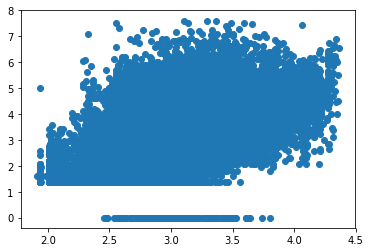

In [81]:
plt.scatter(pred, yv)

In [82]:
trans = np.log(pred+1)

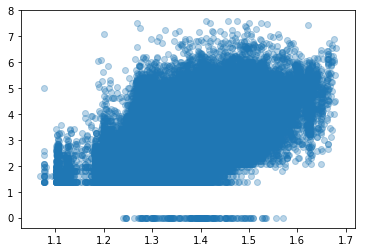

In [83]:
plt.scatter(trans, yv, alpha=.3)

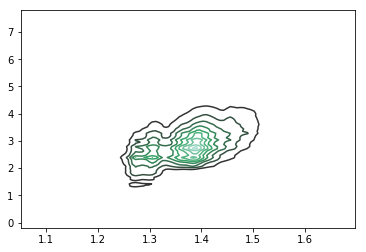

In [84]:
sns.kdeplot(trans, yv)

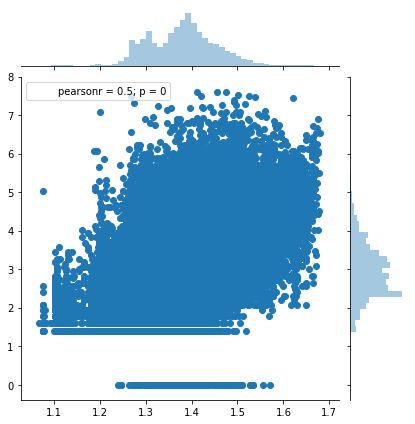

In [85]:
sns.jointplot(trans, yv)

In [86]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, train['price'], test_size=0.2)

In [87]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf2 = GradientBoostingRegressor(**params)

In [88]:
 clf2.fit(Xtr,  ytr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [89]:
pred = clf2.predict(Xv)

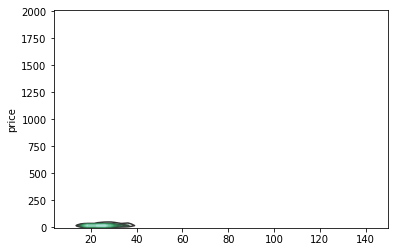

In [90]:
sns.kdeplot(pred, yv)

In [91]:
dvalid = clf.predict(Xv)
dtest = clf.predict(test[feature_names].values)

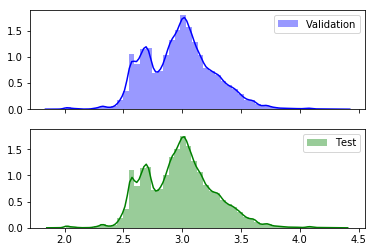

In [93]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(dvalid, ax=ax[0], color='blue', label='Validation')
sns.distplot(dtest, ax=ax[1], color='green', label='Test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)

In [94]:
dvalid = clf2.predict(Xv)
dtest = clf2.predict(test[feature_names].values)

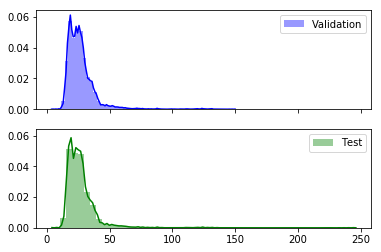

In [95]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(dvalid, ax=ax[0], color='blue', label='Validation')
sns.distplot(dtest, ax=ax[1], color='green', label='Test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)

In [96]:
import pickle

In [97]:
pickle.dump(clf, open('class1.pkl', 'wb'))
pickle.dump(clf2, open('class2.pkl', 'wb'))